In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans


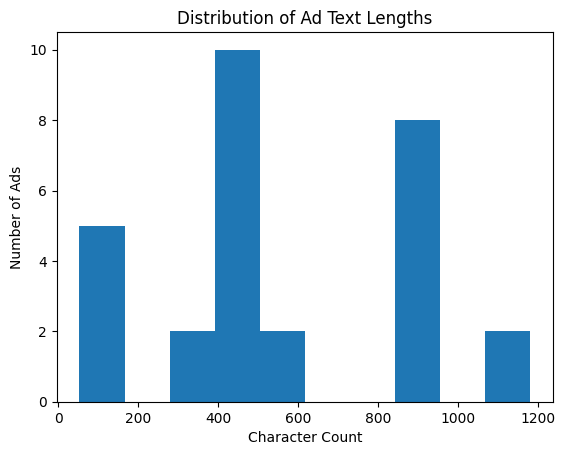

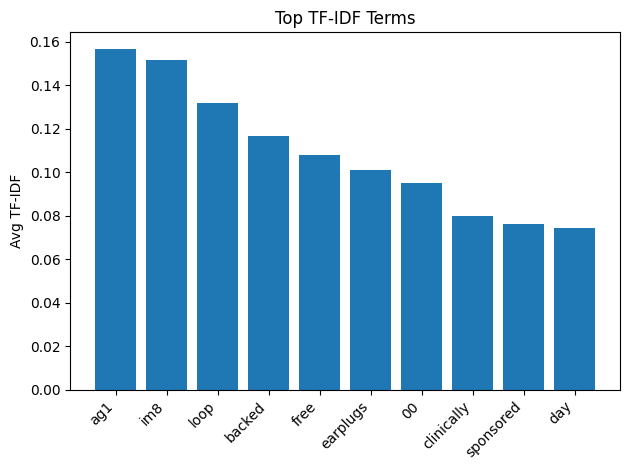

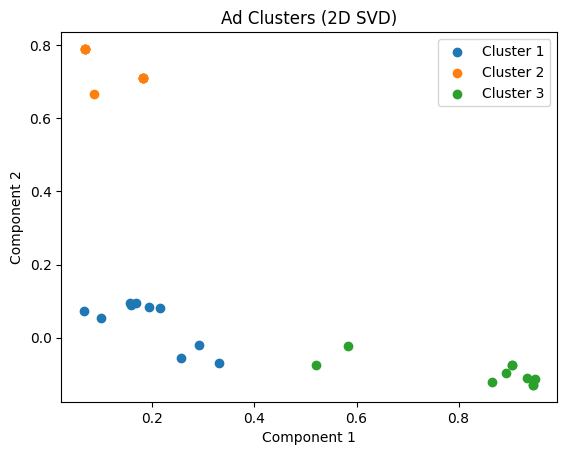

In [ ]:
# 1. Load the JSON
json_path = 'ad_data/top_performing_ads_20250717_180056.json'
with open(json_path, 'r') as f:
    ads = json.load(f)

# 2. Build a DataFrame of key fields
df = pd.DataFrame([{
    'index': ad['index'],
    'text': ad['text_content'],
    'media_count': len(ad['media_urls']),
    'score': ad['performance_score']
} for ad in ads])

# 3. Text‑length distribution
df['text_length'] = df['text'].str.len()
plt.figure()
plt.hist(df['text_length'], bins=10)
plt.title('Distribution of Ad Text Lengths')
plt.xlabel('Character Count')
plt.ylabel('Number of Ads')
plt.show()

# 4. Top TF‑IDF terms
vectorizer = TfidfVectorizer(stop_words='english', max_features=50)
tfidf = vectorizer.fit_transform(df['text'])
terms = vectorizer.get_feature_names_out()
avg_scores = tfidf.mean(axis=0).A1

# Plot the top 10 terms
top_n = 10
idxs = avg_scores.argsort()[::-1][:top_n]
plt.figure()
plt.bar(range(top_n), avg_scores[idxs])
plt.xticks(range(top_n), terms[idxs], rotation=45, ha='right')
plt.title('Top TF‑IDF Terms')
plt.ylabel('Avg TF‑IDF')
plt.tight_layout()
plt.show()

# 5. 2D embedding + clustering
svd = TruncatedSVD(n_components=2, random_state=42)
coords = svd.fit_transform(tfidf)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(coords)

plt.figure()
for c in range(3):
    plt.scatter(coords[clusters==c,0], coords[clusters==c,1], label=f'Cluster {c+1}')
plt.title('Ad Clusters (2D SVD)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()


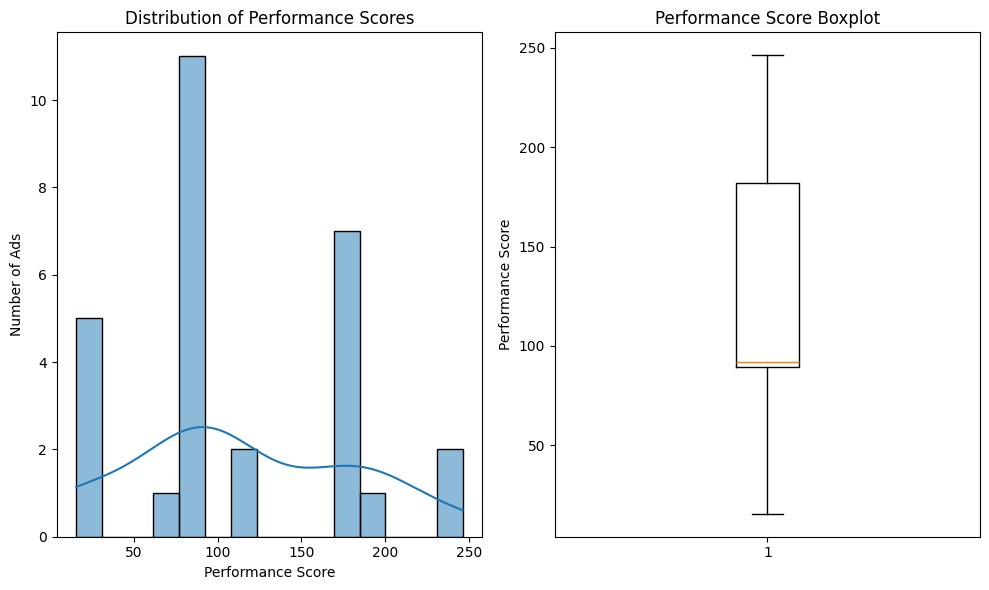

Performance Score Statistics:
Mean: 114.46
Median: 92.00
Std: 67.20
Min: 15.60
Max: 246.20


In [3]:
# ADVANCED INSIGHTS - Performance Score Analysis
import seaborn as sns

# 1. Performance Score Distribution
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['score'], bins=15, kde=True)
plt.title('Distribution of Performance Scores')
plt.xlabel('Performance Score')
plt.ylabel('Number of Ads')

plt.subplot(1, 2, 2)
plt.boxplot(df['score'])
plt.title('Performance Score Boxplot')
plt.ylabel('Performance Score')
plt.tight_layout()
plt.show()

print(f"Performance Score Statistics:")
print(f"Mean: {df['score'].mean():.2f}")
print(f"Median: {df['score'].median():.2f}")
print(f"Std: {df['score'].std():.2f}")
print(f"Min: {df['score'].min():.2f}")
print(f"Max: {df['score'].max():.2f}")


In [4]:
# Top and Bottom Performing Ads
print("=" * 60)
print("TOP 5 PERFORMING ADS:")
print("=" * 60)
top_ads = df.sort_values('score', ascending=False).head(5)
for idx, row in top_ads.iterrows():
    print(f"Score: {row['score']:.2f} | Length: {row['text_length']} chars | Media: {row['media_count']}")
    print(f"Text: {row['text'][:100]}...")
    print("-" * 50)

print("\n" + "=" * 60)
print("BOTTOM 5 PERFORMING ADS:")
print("=" * 60)
bottom_ads = df.sort_values('score', ascending=True).head(5)
for idx, row in bottom_ads.iterrows():
    print(f"Score: {row['score']:.2f} | Length: {row['text_length']} chars | Media: {row['media_count']}")
    print(f"Text: {row['text'][:100]}...")
    print("-" * 50)


TOP 5 PERFORMING ADS:
Score: 246.20 | Length: 1181 chars | Media: 2
Text: AG1 by Athletic Greens
Sponsored
‼️Tired of the Supplement Guessing Game? Here's a Smarter Choice‼️
...
--------------------------------------------------
Score: 239.00 | Length: 1145 chars | Media: 2
Text: AG1 by Athletic Greens
Sponsored
Bereit, jeden Tag alles zu geben? AG1 unterstützt dich dabei.

AG1 ...
--------------------------------------------------
Score: 185.60 | Length: 878 chars | Media: 2
Text: dan_churchill
with
AG1 by Athletic Greens
Sponsored
Feeling off your game? AG1 Next Gen helps suppor...
--------------------------------------------------
Score: 183.80 | Length: 869 chars | Media: 2
Text: Costconew
with
AG1 by Athletic Greens
Sponsored
Tried a sample of @drinkag1 at Costco today and… WOW...
--------------------------------------------------
Score: 182.00 | Length: 860 chars | Media: 2
Text: AG1 by Athletic Greens
Sponsored
🚨 The Next Generation of AG1 is HERE 🚨
Most supplements aren't clin.

Competitors found: competitor
AG1     10
IM8     10
Loop     9
Name: count, dtype: int64


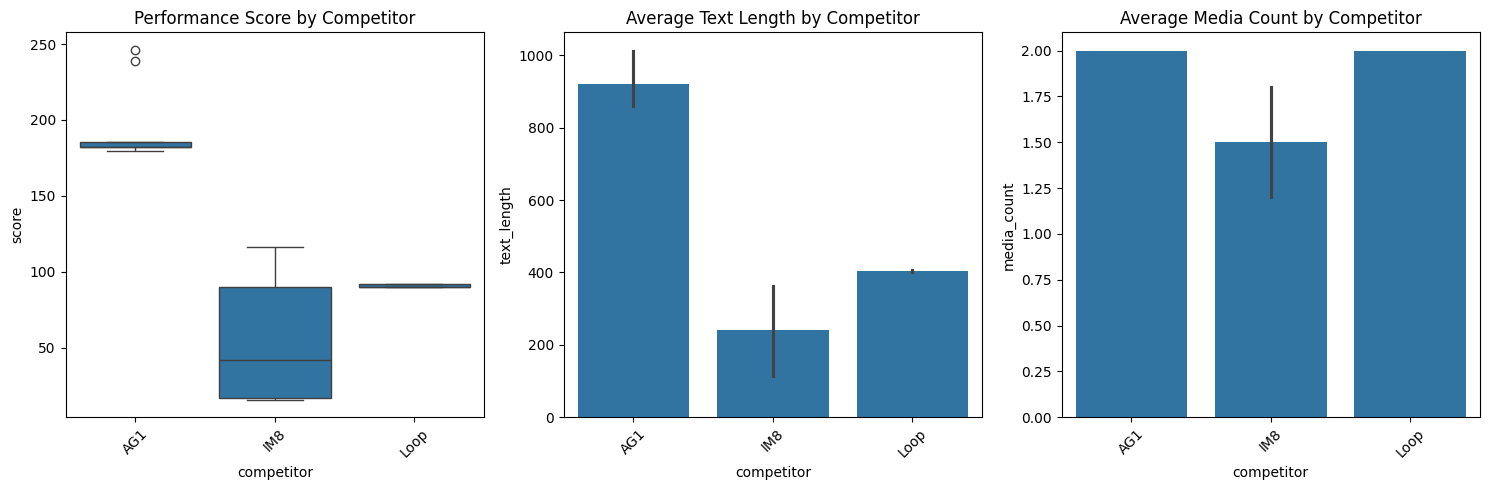


Competitor Performance Summary:
             score              text_length media_count
              mean    std count        mean        mean
competitor                                             
AG1         194.40  25.50    10      922.00         2.0
IM8          55.86  43.81    10      241.80         1.5
Loop         90.73   1.22     9      403.67         2.0


In [5]:
# Extract competitor information from the ads data
df['competitor'] = [ad.get('competitor', 'Unknown') for ad in ads]

# Competitor Analysis
print("Competitors found:", df['competitor'].value_counts())

plt.figure(figsize=(15, 5))

# Score by Competitor
plt.subplot(1, 3, 1)
sns.boxplot(x='competitor', y='score', data=df)
plt.title('Performance Score by Competitor')
plt.xticks(rotation=45)

# Average text length by competitor
plt.subplot(1, 3, 2)
sns.barplot(x='competitor', y='text_length', data=df, estimator='mean')
plt.title('Average Text Length by Competitor')
plt.xticks(rotation=45)

# Media count by competitor
plt.subplot(1, 3, 3)
sns.barplot(x='competitor', y='media_count', data=df, estimator='mean')
plt.title('Average Media Count by Competitor')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Competitor summary stats
print("\nCompetitor Performance Summary:")
competitor_stats = df.groupby('competitor').agg({
    'score': ['mean', 'std', 'count'],
    'text_length': 'mean',
    'media_count': 'mean'
}).round(2)
print(competitor_stats)


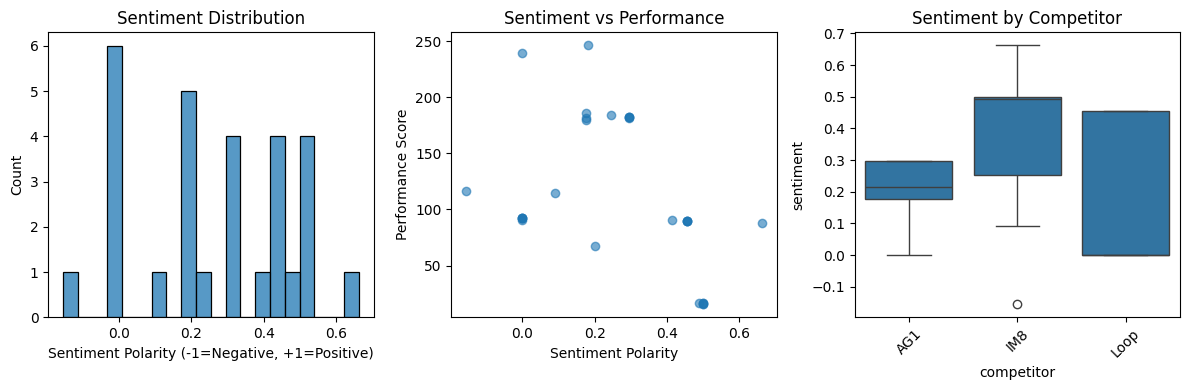

Correlation between Sentiment and Performance Score: -0.424

Performance by Sentiment Category:
                          mean  count
sentiment_category                   
Negative            116.200000      1
Neutral             115.971429      7
Positive            113.866667     21


/var/folders/mz/9lk9vcqx205045ssc401c54h0000gn/T/ipykernel_81313/2148170529.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sentiment_performance = df.groupby('sentiment_category')['score'].agg(['mean', 'count'])


In [11]:
# Sentiment Analysis
try:
    from textblob import TextBlob
    
    def get_sentiment(text):
        return TextBlob(text).sentiment.polarity
    
    df['sentiment'] = df['text'].apply(get_sentiment)
    
    plt.figure(figsize=(12, 4))
    
    # Sentiment distribution
    plt.subplot(1, 3, 1)
    sns.histplot(df['sentiment'], bins=20)
    plt.title('Sentiment Distribution')
    plt.xlabel('Sentiment Polarity (-1=Negative, +1=Positive)')
    
    # Sentiment vs Performance
    plt.subplot(1, 3, 2)
    plt.scatter(df['sentiment'], df['score'], alpha=0.6)
    plt.xlabel('Sentiment Polarity')
    plt.ylabel('Performance Score')
    plt.title('Sentiment vs Performance')
    
    # Sentiment by competitor
    plt.subplot(1, 3, 3)
    sns.boxplot(x='competitor', y='sentiment', data=df)
    plt.title('Sentiment by Competitor')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Correlation analysis
    correlation = df[['sentiment', 'score']].corr().iloc[0,1]
    print(f"Correlation between Sentiment and Performance Score: {correlation:.3f}")
    
    # Sentiment categories
    df['sentiment_category'] = pd.cut(df['sentiment'], 
                                    bins=[-1, -0.1, 0.1, 1], 
                                    labels=['Negative', 'Neutral', 'Positive'])
    sentiment_performance = df.groupby('sentiment_category')['score'].agg(['mean', 'count'])
    print("\nPerformance by Sentiment Category:")
    print(sentiment_performance)
    
except ImportError:
    print("TextBlob not available. Install with: pip install textblob")
    print("Skipping sentiment analysis...")


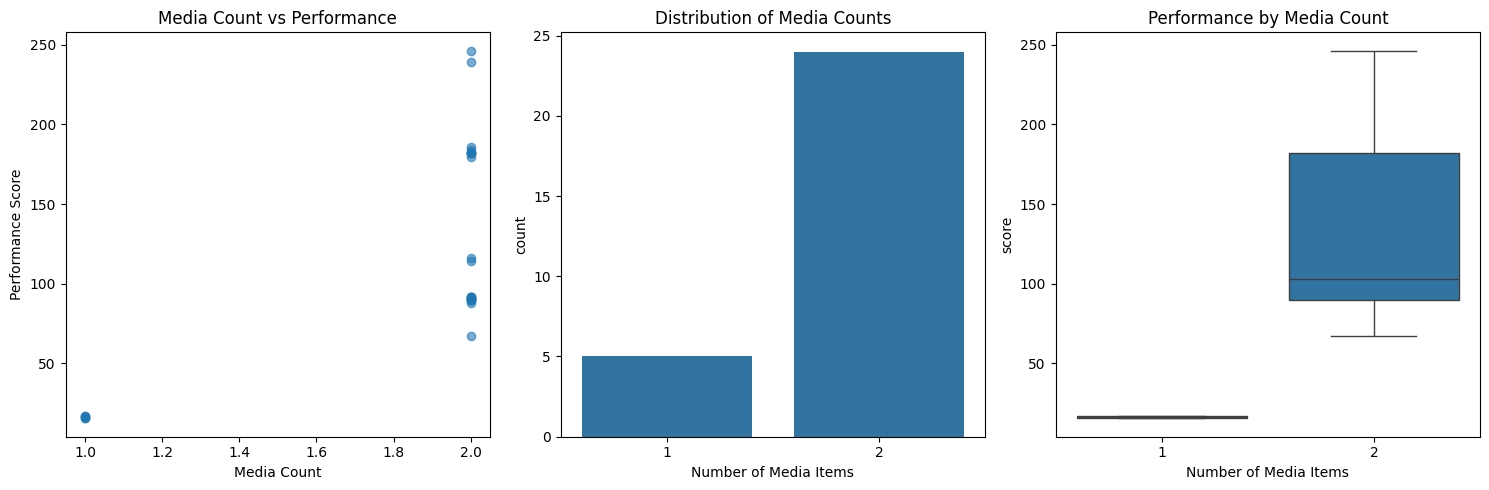

Correlation between Media Count and Performance: 0.678

Media Count Statistics:
               mean    std  count
media_count                      
1             16.36   0.62      5
2            134.89  54.50     24


In [7]:
# Media Analysis
plt.figure(figsize=(15, 5))

# Media count vs Performance
plt.subplot(1, 3, 1)
plt.scatter(df['media_count'], df['score'], alpha=0.6)
plt.xlabel('Media Count')
plt.ylabel('Performance Score')
plt.title('Media Count vs Performance')

# Media count distribution
plt.subplot(1, 3, 2)
sns.countplot(x='media_count', data=df)
plt.title('Distribution of Media Counts')
plt.xlabel('Number of Media Items')

# Performance by media count
plt.subplot(1, 3, 3)
sns.boxplot(x='media_count', y='score', data=df)
plt.title('Performance by Media Count')
plt.xlabel('Number of Media Items')

plt.tight_layout()
plt.show()

# Media count correlation
media_corr = df[['media_count', 'score']].corr().iloc[0,1]
print(f"Correlation between Media Count and Performance: {media_corr:.3f}")

# Media count statistics
print("\nMedia Count Statistics:")
media_stats = df.groupby('media_count')['score'].agg(['mean', 'std', 'count']).round(2)
print(media_stats)


LDA Topics (Top words per topic):
Topic 1: im8, 00, arynasabalenka, coach, health, sponsored, just, im8health
Topic 2: ag1, free, earplugs, gen, nutrient, loop, backed, clinical
Topic 3: loop, les, et, tu, que, oreille, des, volume
Topic 4: day, ag1, routine, just, best, com, learn, loved


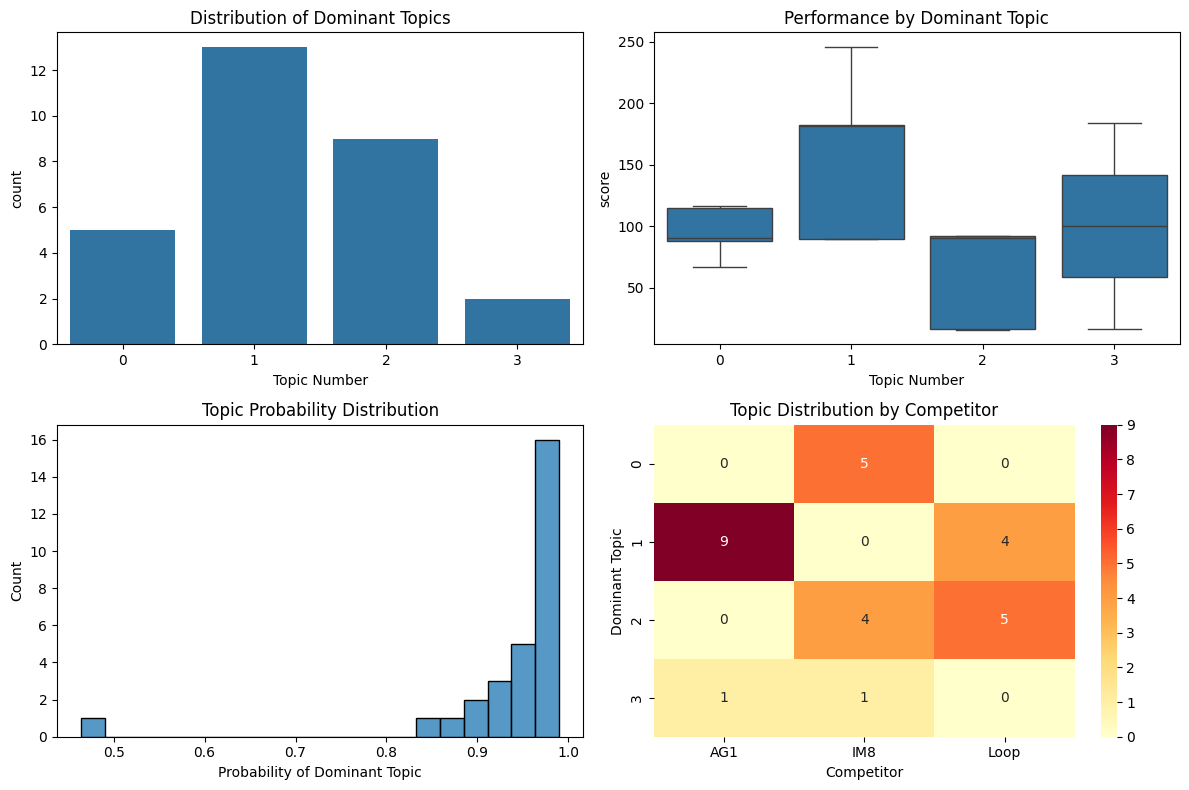


Topic Performance Analysis:
                 score               text_length media_count
                  mean     std count        mean        mean
dominant_topic                                              
0                95.36   20.44     5      426.80        2.00
1               162.97   55.40    13      764.85        2.00
2                58.16   39.71     9      251.89        1.56
3               100.20  118.23     2      463.50        1.50


In [8]:
# Topic Modeling with LDA
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Prepare data for LDA
vectorizer_lda = CountVectorizer(stop_words='english', max_features=100, min_df=2)
X_lda = vectorizer_lda.fit_transform(df['text'])

# Fit LDA model
n_topics = 4
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, max_iter=10)
lda_topics = lda.fit_transform(X_lda)

# Function to display top words for each topic
def print_top_words(model, feature_names, n_top_words=8):
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

print("LDA Topics (Top words per topic):")
print_top_words(lda, vectorizer_lda.get_feature_names_out())

# Assign dominant topic to each ad
df['dominant_topic'] = lda_topics.argmax(axis=1)
df['topic_probability'] = lda_topics.max(axis=1)

# Visualize topics
plt.figure(figsize=(12, 8))

# Topic distribution
plt.subplot(2, 2, 1)
sns.countplot(x='dominant_topic', data=df)
plt.title('Distribution of Dominant Topics')
plt.xlabel('Topic Number')

# Performance by topic
plt.subplot(2, 2, 2)
sns.boxplot(x='dominant_topic', y='score', data=df)
plt.title('Performance by Dominant Topic')
plt.xlabel('Topic Number')

# Topic probability distribution
plt.subplot(2, 2, 3)
sns.histplot(df['topic_probability'], bins=20)
plt.title('Topic Probability Distribution')
plt.xlabel('Probability of Dominant Topic')

# Topic by competitor
plt.subplot(2, 2, 4)
topic_competitor = pd.crosstab(df['dominant_topic'], df['competitor'])
sns.heatmap(topic_competitor, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Topic Distribution by Competitor')
plt.xlabel('Competitor')
plt.ylabel('Dominant Topic')

plt.tight_layout()
plt.show()

# Topic performance analysis
print("\nTopic Performance Analysis:")
topic_stats = df.groupby('dominant_topic').agg({
    'score': ['mean', 'std', 'count'],
    'text_length': 'mean',
    'media_count': 'mean'
}).round(2)
print(topic_stats)


TOP 15 KEYWORDS IN HIGH-PERFORMING ADS:

TOP 15 KEYWORDS IN LOW-PERFORMING ADS:

Keywords unique to high-performing ads: []


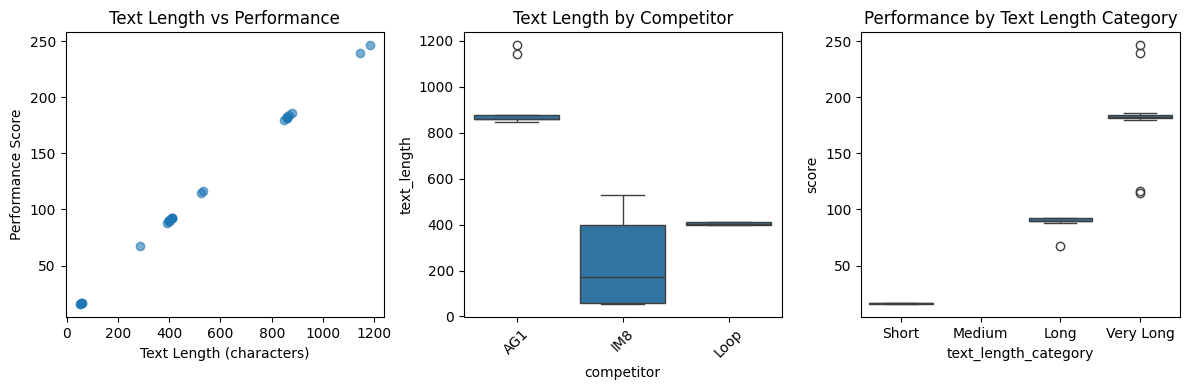


Correlation between Text Length and Performance: 1.000


In [9]:
# Advanced Text Analysis - Keywords and Phrases
import re
from collections import Counter

# Extract common keywords and phrases
def extract_keywords(text, min_length=3):
    # Convert to lowercase and extract words
    words = re.findall(r'\b[a-zA-Z]{' + str(min_length) + ',}\b', text.lower())
    return words

# Get all keywords from high vs low performing ads
high_perf_threshold = df['score'].quantile(0.75)
low_perf_threshold = df['score'].quantile(0.25)

high_perf_ads = df[df['score'] >= high_perf_threshold]
low_perf_ads = df[df['score'] <= low_perf_threshold]

# Extract keywords
high_perf_keywords = []
low_perf_keywords = []

for text in high_perf_ads['text']:
    high_perf_keywords.extend(extract_keywords(text))

for text in low_perf_ads['text']:
    low_perf_keywords.extend(extract_keywords(text))

# Count most common keywords
high_perf_counter = Counter(high_perf_keywords)
low_perf_counter = Counter(low_perf_keywords)

print("=" * 50)
print("TOP 15 KEYWORDS IN HIGH-PERFORMING ADS:")
print("=" * 50)
for word, count in high_perf_counter.most_common(15):
    print(f"{word}: {count}")

print("\n" + "=" * 50)
print("TOP 15 KEYWORDS IN LOW-PERFORMING ADS:")
print("=" * 50)
for word, count in low_perf_counter.most_common(15):
    print(f"{word}: {count}")

# Find unique keywords to high performers
high_only = set(high_perf_keywords) - set(low_perf_keywords)
print(f"\nKeywords unique to high-performing ads: {list(high_only)[:20]}")

# Text length analysis by performance
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.scatter(df['text_length'], df['score'], alpha=0.6)
plt.xlabel('Text Length (characters)')
plt.ylabel('Performance Score')
plt.title('Text Length vs Performance')

plt.subplot(1, 3, 2)
sns.boxplot(x='competitor', y='text_length', data=df)
plt.title('Text Length by Competitor')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
# Create text length categories
df['text_length_category'] = pd.cut(df['text_length'], 
                                   bins=[0, 100, 200, 500, float('inf')], 
                                   labels=['Short', 'Medium', 'Long', 'Very Long'])
sns.boxplot(x='text_length_category', y='score', data=df)
plt.title('Performance by Text Length Category')

plt.tight_layout()
plt.show()

# Text length correlation
length_corr = df[['text_length', 'score']].corr().iloc[0,1]
print(f"\nCorrelation between Text Length and Performance: {length_corr:.3f}")


In [10]:
# Final Summary and Insights
print("=" * 60)
print("SUMMARY OF KEY INSIGHTS")
print("=" * 60)

# Overall statistics
print(f"Total ads analyzed: {len(df)}")
print(f"Average performance score: {df['score'].mean():.2f}")
print(f"Best performing ad score: {df['score'].max():.2f}")
print(f"Worst performing ad score: {df['score'].min():.2f}")

# Best competitor
if 'competitor' in df.columns:
    best_competitor = df.groupby('competitor')['score'].mean().idxmax()
    best_score = df.groupby('competitor')['score'].mean().max()
    print(f"Best performing competitor: {best_competitor} (avg score: {best_score:.2f})")

# Correlation insights
print(f"\nKey Correlations:")
print(f"- Text length vs Performance: {df[['text_length', 'score']].corr().iloc[0,1]:.3f}")
print(f"- Media count vs Performance: {df[['media_count', 'score']].corr().iloc[0,1]:.3f}")

if 'sentiment' in df.columns:
    print(f"- Sentiment vs Performance: {df[['sentiment', 'score']].corr().iloc[0,1]:.3f}")

# Performance insights
high_performers = df[df['score'] >= df['score'].quantile(0.8)]
low_performers = df[df['score'] <= df['score'].quantile(0.2)]

print(f"\nHigh Performers (top 20%) characteristics:")
print(f"- Average text length: {high_performers['text_length'].mean():.0f} chars")
print(f"- Average media count: {high_performers['media_count'].mean():.1f}")
if 'sentiment' in df.columns:
    print(f"- Average sentiment: {high_performers['sentiment'].mean():.3f}")

print(f"\nLow Performers (bottom 20%) characteristics:")
print(f"- Average text length: {low_performers['text_length'].mean():.0f} chars")
print(f"- Average media count: {low_performers['media_count'].mean():.1f}")
if 'sentiment' in df.columns:
    print(f"- Average sentiment: {low_performers['sentiment'].mean():.3f}")

print("\n" + "=" * 60)
print("RECOMMENDATIONS:")
print("=" * 60)
print("1. Analyze the top-performing ads' text patterns for content strategy")
print("2. Consider optimal text length based on correlation analysis")
print("3. Evaluate media strategy based on performance correlations")
if 'sentiment' in df.columns:
    print("4. Consider sentiment analysis results for tone optimization")
print("5. Study competitor strategies, especially the best performer")
print("6. Focus on topics/themes that show highest performance scores")


SUMMARY OF KEY INSIGHTS
Total ads analyzed: 29
Average performance score: 114.46
Best performing ad score: 246.20
Worst performing ad score: 15.60
Best performing competitor: AG1 (avg score: 194.40)

Key Correlations:
- Text length vs Performance: 1.000
- Media count vs Performance: 0.678

High Performers (top 20%) characteristics:
- Average text length: 950 chars
- Average media count: 2.0

Low Performers (bottom 20%) characteristics:
- Average text length: 95 chars
- Average media count: 1.2

RECOMMENDATIONS:
1. Analyze the top-performing ads' text patterns for content strategy
2. Consider optimal text length based on correlation analysis
3. Evaluate media strategy based on performance correlations
5. Study competitor strategies, especially the best performer
6. Focus on topics/themes that show highest performance scores
